In [1]:
# Import library
import re
import pandas as pd
from datetime import datetime
import pickle

In [2]:
pwd

'C:\\Users\\IDE602\\OneDrive\\Course\\PKNU\\Research\\Experiment_patent\\01. Bio Healthcare Dataset'

In [7]:
# import necessary libraries
import nltk
nltk.download('stopwords')

import spacy  # for lemmatization

#preprocessing and building model with gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess 
from gensim.parsing.preprocessing import STOPWORDS # stopwords with gensim available 
from gensim.models import CoherenceModel
from gensim.models import Phrases # making biagrams and triagras to text
from gensim.corpora import Dictionary #creating a dictionary and corpus
from gensim.models import LdaModel #building the LDA Model
from gensim.models import LdaSeqModel #building the Dynamic Topic Modelling LDA Model

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\IDE602\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Load Data
data = pd.read_excel('C:\\Users\\IDE602\\OneDrive\\Course\\PKNU\\Research\\Experiment_patent\\01. Bio Healthcare Dataset/Dataset/healthcare_12-20.xlsx') # consist of title, abstract, representative claim, IPC, and Years
data['Text'] = data['Title']+" "+data['Abstract']+" "+data['Representative Claim'] # combine all of the text to be one column
df = pd.DataFrame(data, columns=['Text','Years']) # make dataframe text and years
# sorted by years
df = df.sort_values(by=['Years'])
df = df.reset_index(drop=True)

In [4]:
df

,Text,Years
0,CONDUCTIVITY SENSOR ASSEMBLY A flow-through co...,2012
1,Segmenting an organ in a medical digital image...,2012
2,Distributed control system for hospitality man...,2012
3,Vaccine stabilizer Disclosed herein is a formu...,2012
4,Simulator device A simulator device configured...,2012
...,...,...
1760,Method for Preparation of Liquid Mixtures The ...,2020
1761,APPARATUS AND METHOD TO SUPPORT ULTRA-WIDE BAN...,2020
1762,METHOD AND APPARATUS FOR DATA TRANSMISSION IN ...,2020
1763,BLOCKCHAIN-BASED MECHANISMS FOR SECURE HEALTH ...,2020


In [5]:
#Split document based on years
period_1 = df[(df['Years']==2012) | (df['Years']==2013)| (df['Years']==2014)]
period_2 = df[(df['Years']==2015) | (df['Years']==2016)| (df['Years']==2017)]
period_3 = df[(df['Years']==2018) | (df['Years']==2019)| (df['Years']==2020)]

# amount of each period
print('periode_1:',len(period_1))
print('periode_2:', len(period_2))
print('periode_3:', len(period_3))

periode_1: 537
periode_2: 691
periode_3: 537


In [8]:
# text preprocessing

# 1. Lowercase
df["Text"] = df["Text"].str.lower()
# 2. Remove special characters
df["Text"] = df["Text"].replace('[^\w\s]','')
# 3. Tokenization
df["Text"] = df["Text"].apply(gensim.utils.simple_preprocess)
# 4. Remove stopwords
stop_words = set(gensim.parsing.preprocessing.STOPWORDS)
df["Text"] = df["Text"].apply(lambda x: [word for word in x if word not in stop_words])

In [9]:
# # data ready after preprocessing
data_ready = df['Text']

In [10]:
# Create a dictionary representation of the documents.
id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

# Filter out words that occur less than 10 documents, or more than 20% of the documents
id2word.filter_extremes(no_below=10, no_above=0.2)
print('Number of unique words after removing rare and common words:', len(id2word))

# Corpus / DTM (document word matrix) generation
corpus = [id2word.doc2bow(doc) for doc in data_ready]

print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))

Total Vocabulary Size: 7841
Number of unique words after removing rare and common words: 1923
Number of unique tokens: 1923
Number of documents: 1765


In [11]:
# different values of alpha and beta(eta) to increase the coherence score. High coherence score is good for our model

In [12]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=70, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.7,
                                           per_word_topics=True,
                                           eta = 0.5)

In [13]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.5072479532313519


In [14]:
# Document_topic distribution
lda_output = ([list(dict(lda_model.get_document_topics(doc, minimum_probability=0)).values()) for doc in corpus])


In [15]:
len(lda_output)

1765

In [16]:
num_topics = 70
# column names
topicnames = ['T' + str(i+1) for i in range(num_topics)]

# index names
docnames = ['Doc' + str(i+1) for i in range(len(df))]

# make the dataframe the value based on weight of topic
df_doc_topic = pd.DataFrame(lda_output, columns=topicnames, index = docnames)
df_doc_topic

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,...,T61,T62,T63,T64,T65,T66,T67,T68,T69,T70
Doc1,0.006383,0.006309,0.006371,0.006329,0.006720,0.006720,0.031814,0.006720,0.006720,0.006636,...,0.006302,0.006416,0.006305,0.006363,0.006720,0.006720,0.008821,0.006684,0.006886,0.006437
Doc2,0.005486,0.006015,0.009448,0.034365,0.005782,0.005782,0.006233,0.005782,0.005782,0.005678,...,0.005701,0.006104,0.005886,0.005481,0.005782,0.005782,0.005994,0.005604,0.005490,0.006199
Doc3,0.019692,0.016615,0.012835,0.004435,0.003723,0.003723,0.005840,0.003723,0.003723,0.007068,...,0.043103,0.003835,0.055276,0.248296,0.003723,0.003723,0.003620,0.005370,0.003523,0.003579
Doc4,0.008098,0.007995,0.008070,0.008141,0.008267,0.008267,0.008626,0.008267,0.008267,0.008144,...,0.008897,0.008730,0.007965,0.009449,0.008267,0.008267,0.007993,0.008641,0.029881,0.007970
Doc5,0.005789,0.005751,0.005736,0.006111,0.005926,0.005926,0.005754,0.005926,0.005926,0.005746,...,0.005966,0.009025,0.005757,0.007570,0.005926,0.005926,0.005888,0.005750,0.005788,0.005771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Doc1761,0.009257,0.010153,0.025705,0.008640,0.008608,0.008608,0.009752,0.008608,0.008608,0.008500,...,0.008544,0.008621,0.008658,0.008888,0.008608,0.008608,0.008686,0.009055,0.008633,0.008592
Doc1762,0.004781,0.646777,0.004711,0.004912,0.004786,0.004786,0.004915,0.004786,0.004786,0.004701,...,0.005761,0.004835,0.005086,0.004864,0.004786,0.004786,0.004684,0.004732,0.004687,0.004691
Doc1763,0.005161,0.498858,0.005099,0.004906,0.005057,0.005057,0.005710,0.005057,0.005057,0.062504,...,0.006243,0.004821,0.014955,0.004880,0.005057,0.005057,0.004813,0.005472,0.004795,0.004865
Doc1764,0.005758,0.006964,0.006152,0.018722,0.005559,0.005559,0.005680,0.005559,0.005559,0.005835,...,0.140538,0.013001,0.089085,0.005458,0.005559,0.005559,0.005769,0.005928,0.005493,0.005452


In [17]:
# df doc-topic matrix period 1 with len: 537
doc_topic_1 = df_doc_topic.iloc[0 : len(period_1)]
print('doc_1:',len(doc_topic_1))
# df doc-topic matrix period 2 with len : 691
doc_topic_2 = df_doc_topic.iloc[len(doc_topic_1) : len(doc_topic_1) + len(period_2)]
print('doc_2:',len(doc_topic_2))
# df doc-topic matrix period 3 with len : 537
doc_topic_3 = df_doc_topic.iloc[len(doc_topic_1) + len(doc_topic_2) : ]
print('doc_3:',len(doc_topic_3))

doc_1: 537
doc_2: 691
doc_3: 537


In [61]:
# save dataframe
# doc_topic_1.to_excel('doc_topic_1_Gensim.xlsx')
# doc_topic_2.to_excel('doc_topic_2_Gensim.xlsx')
# doc_topic_3.to_excel('doc_topic_3_Gensim.xlsx')

In [19]:
# lda_model.print_topics(70)

# Network

In [20]:
import numpy as np
import math
import statistics

#calculate doc_topic weight 
print('percentile 0.9:',np.percentile(doc_topic_1.iloc[0], 90))
print('percentile 0.95:',np.percentile(doc_topic_1.iloc[0],95))
print('mean:',statistics.mean(doc_topic_1.iloc[0]))
print('minimum:',np.min(doc_topic_1.iloc[0]))
print('quartile 75%:',np.quantile(doc_topic_1.iloc[0],0.75))

percentile 0.9: 0.01782571449875832
percentile 0.95: 0.050932222045957945
mean: 0.01428571481124631
minimum: 0.006301756948232651
quartile 75%: 0.006720082834362984


In [21]:
#specify weight limit with mean
import numpy as np
weight_1 = []
for i in range(len(doc_topic_1)) : 
  value_i = np.quantile(doc_topic_1.iloc[i],0.75)
  weight_1.append(value_i)

In [22]:
# get a binarry dataframe to support creating adjacency matrix
matrix_1 = []
data_1 = []
for i in range(len(doc_topic_1)) :
  for j in range(70) :
    if doc_topic_1['T' + str(j + 1)][i] > weight_1[i] :
      result = 1 
    else :
      result = 0
    data_1.append(result)
  matrix_1.append(data_1)
  data_1 = []
    
adj_1 = pd.DataFrame(matrix_1, columns = ['T' + str(i) for i in range(1, 71)])
adj_1.head()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,...,T61,T62,T63,T64,T65,T66,T67,T68,T69,T70
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,1,1,0,1,0,0,0,1,1,0
4,0,0,0,1,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0


In [23]:
# library to create network
import scipy.sparse as sp
import networkx as nx
import matplotlib.pyplot as plt

In [28]:
cols_1 = doc_topic_1.columns #list columns of dataframe
X1 = sp.csr_matrix(adj_1.astype(int).values) # matrix values of df quartile 3 (75%)
Xc_1 = X1.T * X1  # multiply sparse matrix (T = transpose)
Xc_1.setdiag(0)  # reset diagonal

# create dataframe from co-occurence matrix in dense format
df_x1 = pd.DataFrame(Xc_1.todense(), index=cols_1, columns=cols_1)

C:\Users\IDE602\anaconda3\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [35]:
#stacking the levels from column to index
df_g1 = df_x1.stack().reset_index()
df_g1.columns = ['source', 'target', 'weight']
df_g1 = df_g1[df_g1['weight'] != 0]  # remove zero value
G1 = nx.from_pandas_edgelist(df_g1, 'source', 'target', create_using = nx.Graph())

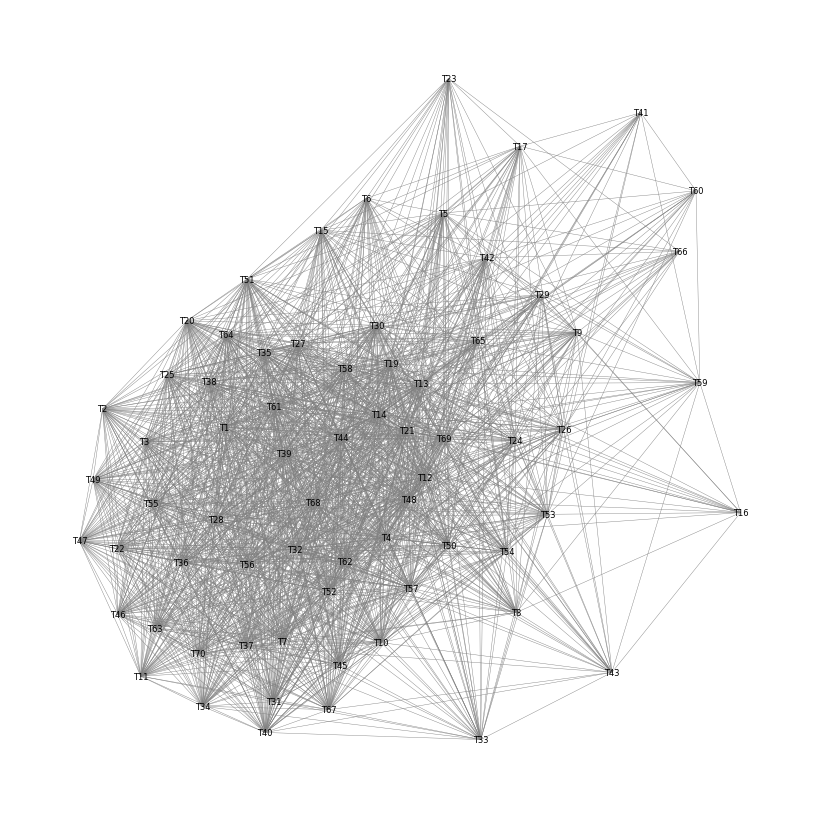

In [36]:
plt.figure(figsize=[8,8])
nx.draw(G1, with_labels=True, font_size=6, width=0.3, node_size=0, edge_color='gray')
plt.show()

In [37]:
# check the number of link prediction index
len(list(nx.jaccard_coefficient(G1)))

634

# Period 2

In [39]:
#calculate doc_topic weight
print('percentile 0.9:',np.percentile(doc_topic_2.iloc[0], 90))
print('quartile 50%:',np.quantile(doc_topic_2.iloc[0],0.50))
print('mean:',statistics.mean(doc_topic_2.iloc[0]))
print('minimum:',np.min(doc_topic_2.iloc[0]))
print('quartile 75%:',np.quantile(doc_topic_2.iloc[0],0.75))

percentile 0.9: 0.023974647931754602
quartile 50%: 0.004433191381394863
mean: 0.014285714731418661
minimum: 0.004247106611728668
quartile 75%: 0.005159557447768748


In [40]:
import numpy as np
weight_2 = []
for i in range(len(doc_topic_2)) : 
  percentile_i = np.quantile(doc_topic_2.iloc[i], 0.75)
  weight_2.append(percentile_i)
print(len(weight_2))

691


In [43]:
# get a binarry dataframe to support creating adjacency matrix
matrix_2 = []
data_2 = []
for i in range(len(doc_topic_2)) :
  for j in range(70) :
    if doc_topic_2['T' + str(j + 1)][i] > weight_2[i] :
      result = 1 
    else :
      result = 0
    data_2.append(result)
  matrix_2.append(data_2)
  data_2 = []

    
adj_2 = pd.DataFrame(matrix_2, columns = ['T' + str(i) for i in range(1, 71)])
adj_2.head()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,...,T61,T62,T63,T64,T65,T66,T67,T68,T69,T70
0,1,1,0,1,0,0,0,0,0,0,...,1,0,1,1,0,0,0,0,0,1
1,0,0,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,1,1
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0,1,0,1,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
4,1,0,1,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,1,0,0


In [45]:
cols_2 = adj_2.columns #list columns of dataframe
X2 = sp.csr_matrix(adj_2.astype(int).values) # matrix values of df quartile 3 (75%)
Xc_2 = X2.T * X2  # multiply sparse matrix (T = transpose)
Xc_2.setdiag(0)  # reset diagonal

# create dataframe from co-occurence matrix in dense format
df_x2 = pd.DataFrame(Xc_2.todense(), index=cols_2, columns=cols_2)


#stacking the levels from column to index
df_g2 = df_x2.stack().reset_index()
df_g2.columns = ['source', 'target', 'weight']
df_g2 = df_g2[df_g2['weight'] != 0]  # remove non-connected nodes
G2 = nx.from_pandas_edgelist(df_g2, 'source', 'target', create_using = nx.Graph())

C:\Users\IDE602\anaconda3\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


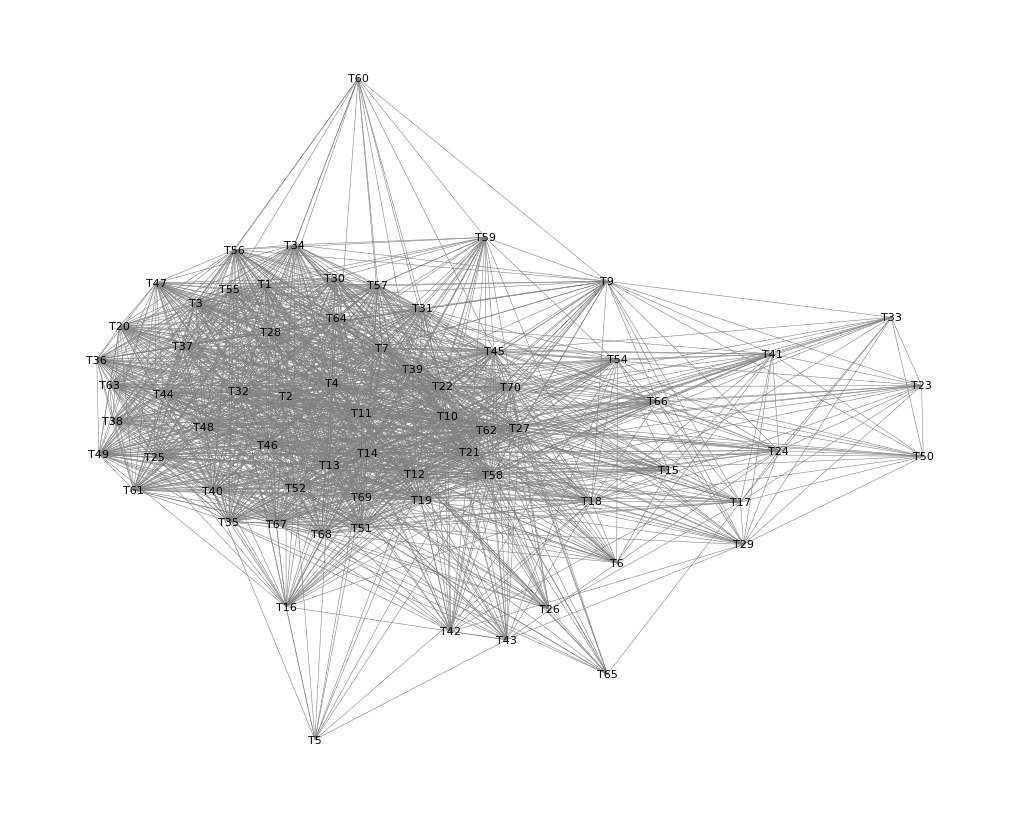

In [46]:
plt.figure(figsize=[10,8])
nx.draw(G2, with_labels=True, font_size=8, width=0.4, node_size=0, edge_color='gray')
plt.show()

In [47]:
# check the number of link prediction index
len(list(nx.jaccard_coefficient(G2)))

748

# Period 3

In [48]:
weight_number3 = []
for i in range(len(doc_topic_3)) : 
  percentile_i = np.quantile(doc_topic_3.iloc[i], 0.75)
  weight_number3.append(percentile_i)
print(len(weight_number3))

537


In [49]:
# get binarry dataframe to support creating adjecency matrix
matrix_3 = []
data_3 = []
for i in range(len(doc_topic_3)) :
  for j in range(70) :
    if doc_topic_3['T' + str(j + 1)][i] > weight_number3[i] :
      result = 1 
    else :
      result = 0
    data_3.append(result)
  matrix_3.append(data_3)
  data_3 = []
    
adj_3 = pd.DataFrame(matrix_3, columns = ['T' + str(i+1) for i in range(70)])
adj_3.head()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,...,T61,T62,T63,T64,T65,T66,T67,T68,T69,T70
0,0,1,1,1,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,0,0,...,1,0,1,1,0,0,0,1,0,0
2,1,0,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,1
3,1,1,1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,1,1,0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,1


In [50]:
cols_3 = adj_3.columns #list columns of dataframe
X3 = sp.csr_matrix(adj_3.astype(int).values) # matrix values of df quartile 3 (75%)
Xc_3 = X3.T * X3  # multiply sparse matrix (T = transpose)
Xc_3.setdiag(0)  # reset diagonal

# create dataframe from co-occurence matrix in dense format
df_x3 = pd.DataFrame(Xc_3.todense(), index=cols_3, columns=cols_3)

C:\Users\IDE602\anaconda3\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [56]:
#stacking the levels from column to index
df_g3 = df_x3.stack().reset_index()
df_g3.columns = ['source', 'target', 'weight']
df_g3 = df_g3[df_g3['weight'] != 0]  # remove non-connected nodes
G3 = nx.from_pandas_edgelist(df_g3, 'source', 'target', create_using = nx.Graph())

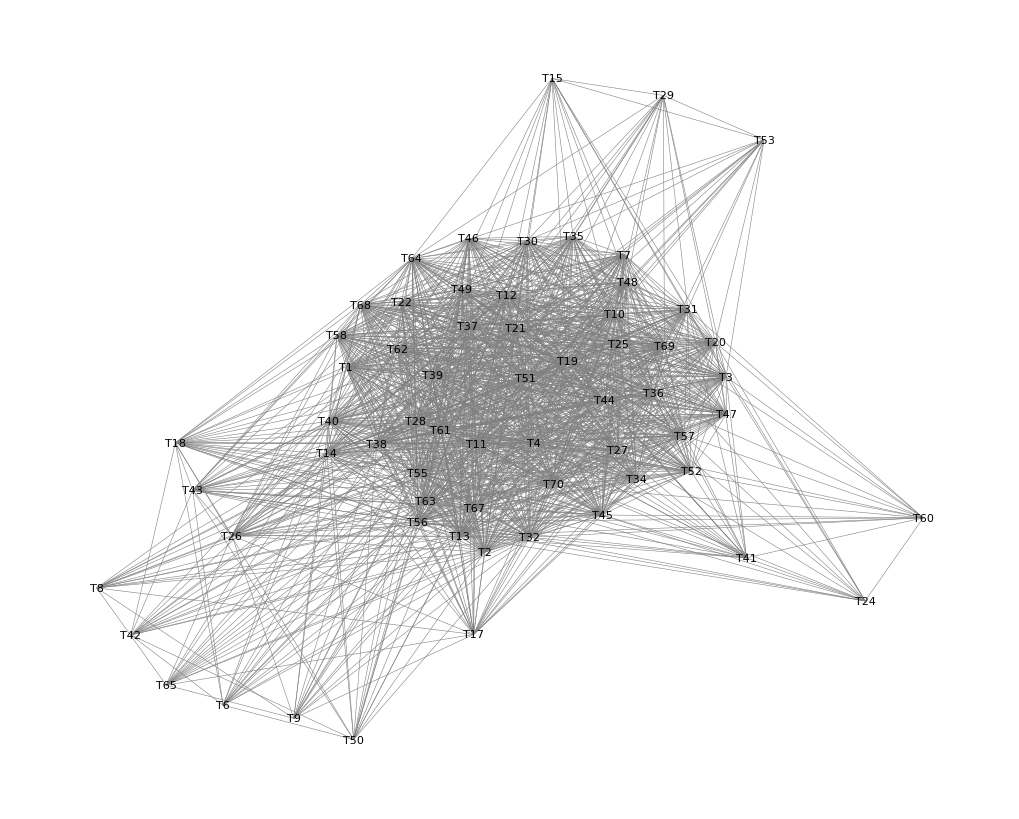

In [57]:
plt.figure(figsize=[10,8])
nx.draw(G3, with_labels=True, font_size=8, width=0.4, node_size=0, edge_color='gray')
plt.show()

In [59]:
# check the number of link prediction index
len(list(nx.jaccard_coefficient(G3)))

572

In [68]:
adj_1.to_excel('Adj_1_GensimT70.xlsx', index=False)
adj_2.to_excel('Adj_2_GensimT70.xlsx', index=False)
adj_3.to_excel('Adj_3_GensimT70.xlsx', index=False)

In [53]:
# Save graph
import pickle

graph_1 = "Graph_1_GensimT70.pickle"
graph_2 = "Graph_2_GensimT70.pickle"
graph_3 = "Graph_3_GensimT70.pickle"

# save model
pickle.dump(G1, open(graph_1, "wb"))
pickle.dump(G2, open(graph_2, "wb"))
pickle.dump(G3, open(graph_3, "wb"))

# Extract feature

In [60]:
# Compute Jaccard index
jc = pd.DataFrame(list(nx.jaccard_coefficient(G1)), columns=['node_1', 'node_2', 'jaccard'])

# Compute PageRank index
pr = pd.DataFrame(nx.pagerank(G1).items(), columns=['node', 'pagerank'])

# Compute Katz index
beta = 0.1
katz = pd.DataFrame(nx.katz_centrality_numpy(G1, beta=beta).items(), columns=['node', 'katz'])

# compute subgraph_centrality
# subg = pd.DataFrame(nx.subgraph_centrality(G1).items(), columns=['node', 'subgraph'])

# compute triangles
tri = pd.DataFrame(nx.triangles(G1).items(), columns=['node', 'tri'])

# compute clustering
cls = pd.DataFrame(nx.clustering(G1).items(), columns=['node', 'clstr'])

# compute eigenvector_centrality(G1)
ecen = pd.DataFrame(nx.eigenvector_centrality(G1).items(), columns=['node', 'ecen'])

# compute between_centrality(G1)
bcen = pd.DataFrame(nx.betweenness_centrality(G1).items(), columns=['node', 'bcen'])

# Merge the dataframes based on the node pairs and node labels
df_1 = jc.merge(pr, how='left', left_on='node_1', right_on='node').merge(pr, how='left', left_on='node_2', right_on='node')\
    .merge(katz, how='left', left_on='node_1', right_on='node').merge(katz, how='left', left_on='node_2', right_on='node')\
    .merge(tri, how='left', left_on='node_1', right_on='node').merge(tri, how='left', left_on='node_2', right_on='node')\
    .merge(cls, how='left', left_on='node_1', right_on='node').merge(cls, how='left', left_on='node_2', right_on='node')\
    .merge(ecen, how='left', left_on='node_1', right_on='node').merge(ecen, how='left', left_on='node_2', right_on='node')\
    .merge(bcen, how='left', left_on='node_1', right_on='node').merge(bcen, how='left', left_on='node_2', right_on='node')

# # Drop the duplicate node columns and rename the remaining columns
df_1.drop(['node_x', 'node_y'], axis=1, inplace=True)
df_1.rename(columns={'pagerank_x': 'pagerank_1', 'pagerank_y': 'pagerank_2', 'katz_x': 'katz_1', 'katz_y': 'katz_2', 'tri_x':'tri_1', 'tri_y':'tri_2', 'clstr_x':'clstr_1', 'clstr_y':'clstr_2', 'ecen_x':'ecen_1', 'ecen_y':'ecen_2', 'bcen_x':'bcen_1', 'bcen_y':'bcen_2'}, inplace=True)

# # Add additional features to the dataframe
df_1['cn'] = [len(list(nx.common_neighbors(G1, n1, n2))) for n1, n2 in zip(jc['node_1'], jc['node_2'])]

# Compute SimRank index
simrank_similar_1 = []
for i in range(len(df_1)):
  simrank_similar_1.append(nx.simrank_similarity(G1, source=df_1['node_1'][i], target=df_1['node_2'][i]))

df_1['simrank'] = simrank_similar_1

C:\Users\IDE602\AppData\Local\Temp\ipykernel_29556\3708755846.py:27: FutureWarning: Passing 'suffixes' which cause duplicate columns {'node_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_1 = jc.merge(pr, how='left', left_on='node_1', right_on='node').merge(pr, how='left', left_on='node_2', right_on='node')\
C:\Users\IDE602\AppData\Local\Temp\ipykernel_29556\3708755846.py:27: FutureWarning: Passing 'suffixes' which cause duplicate columns {'node_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_1 = jc.merge(pr, how='left', left_on='node_1', right_on='node').merge(pr, how='left', left_on='node_2', right_on='node')\
C:\Users\IDE602\AppData\Local\Temp\ipykernel_29556\3708755846.py:27: FutureWarning: Passing 'suffixes' which cause duplicate columns {'node_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_1 = jc.merge(pr, how='left', left_on='node_1', right_on='node').merge(pr, how=

In [61]:
print(len(df_1))
df_1.head()

634


,node_1,node_2,jaccard,pagerank_1,pagerank_2,katz_1,katz_2,tri_1,tri_2,clstr_1,clstr_2,ecen_1,ecen_2,bcen_1,bcen_2,cn,simrank
0,T44,T23,0.375000,0.017399,0.008966,0.073341,0.140329,1459,324,0.797268,0.923077,0.140368,0.061682,0.008022,0.000518,24,0.120235
1,T44,T66,0.238095,0.017399,0.006411,0.073341,0.020842,1459,136,0.797268,1.000000,0.140368,0.040794,0.008022,0.000000,15,0.119955
2,T44,T29,0.461538,0.017399,0.010714,0.073341,0.149881,1459,492,0.797268,0.877005,0.140368,0.078472,0.008022,0.001434,30,0.120219
3,T44,T16,0.218750,0.017399,0.006476,0.073341,-0.005931,1459,136,0.797268,1.000000,0.140368,0.038911,0.008022,0.000000,14,0.119149
4,T44,T43,0.375000,0.017399,0.008988,0.073341,0.057120,1459,311,0.797268,0.886040,0.140368,0.061649,0.008022,0.000855,24,0.120259


# Period 2

In [62]:
# Compute Jaccard index
jac_2 = pd.DataFrame(list(nx.jaccard_coefficient(G2)), columns=['node_1', 'node_2', 'jaccard'])

# Compute PageRank index
pr_2 = pd.DataFrame(nx.pagerank(G2).items(), columns=['node', 'pagerank'])

# Compute Katz index
beta = 0.1
katz_2 = pd.DataFrame(nx.katz_centrality_numpy(G2, beta=beta).items(), columns=['node', 'katz'])


# compute triangles
tri_2 = pd.DataFrame(nx.triangles(G2).items(), columns=['node', 'tri'])

# compute clustering
cls_2 = pd.DataFrame(nx.clustering(G2).items(), columns=['node', 'clstr'])

# compute eigenvector_centrality
eig_2 = pd.DataFrame(nx.eigenvector_centrality(G2).items(), columns=['node', 'ecen'])

# compute between_centrality(G1)
bcen_2 = pd.DataFrame(nx.betweenness_centrality(G2).items(), columns=['node', 'bcen'])


# Merge the dataframes based on the node pairs and node labels
df_2 = jac_2.merge(pr_2, how='left', left_on='node_1', right_on='node').merge(pr_2, how='left', left_on='node_2', right_on='node')\
    .merge(katz_2, how='left', left_on='node_1', right_on='node').merge(katz_2, how='left', left_on='node_2', right_on='node')\
    .merge(tri_2, how='left', left_on='node_1', right_on='node').merge(tri_2, how='left', left_on='node_2', right_on='node')\
    .merge(cls_2, how='left', left_on='node_1', right_on='node').merge(cls_2, how='left', left_on='node_2', right_on='node')\
    .merge(eig_2, how='left', left_on='node_1', right_on='node').merge(eig_2, how='left', left_on='node_2', right_on='node')\
    .merge(bcen_2, how='left', left_on='node_1', right_on='node').merge(bcen_2, how='left', left_on='node_2', right_on='node')

# # Drop the duplicate node columns and rename the remaining columns
df_2.drop(['node_x', 'node_y'], axis=1, inplace=True)
df_2.rename(columns={'pagerank_x': 'pagerank_1', 'pagerank_y': 'pagerank_2', 'katz_x': 'katz_1', 'katz_y': 'katz_2', 'tri_x':'tri_1', 
                     'tri_y':'tri_2', 'clstr_x':'clstr_1', 'clstr_y':'clstr_2', 'ecen_x':'ecen_1', 'ecen_y':'ecen_2', 'bcen_x':'bcen_1',
                     'bcen_y':'bcen_2'}, inplace=True)

# # Add additional features to the dataframe
df_2['cn'] = [len(list(nx.common_neighbors(G2, n1, n2))) for n1, n2 in zip(jac_2['node_1'], jac_2['node_2'])]

# Compute SimRank index
simrank_similar_2 = []
for i in range(len(df_2)):
  simrank_similar_2.append(nx.simrank_similarity(G2, source=df_2['node_1'][i], target=df_2['node_2'][i]))
df_2['simrank'] = simrank_similar_2

print(len(df_2))
df_2.head()

C:\Users\IDE602\AppData\Local\Temp\ipykernel_29556\3659862925.py:26: FutureWarning: Passing 'suffixes' which cause duplicate columns {'node_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_2 = jac_2.merge(pr_2, how='left', left_on='node_1', right_on='node').merge(pr_2, how='left', left_on='node_2', right_on='node')\
C:\Users\IDE602\AppData\Local\Temp\ipykernel_29556\3659862925.py:26: FutureWarning: Passing 'suffixes' which cause duplicate columns {'node_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_2 = jac_2.merge(pr_2, how='left', left_on='node_1', right_on='node').merge(pr_2, how='left', left_on='node_2', right_on='node')\
C:\Users\IDE602\AppData\Local\Temp\ipykernel_29556\3659862925.py:26: FutureWarning: Passing 'suffixes' which cause duplicate columns {'node_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_2 = jac_2.merge(pr_2, how='left', left_on='node_1', right_on='no

748


,node_1,node_2,jaccard,pagerank_1,pagerank_2,katz_1,katz_2,tri_1,tri_2,clstr_1,clstr_2,ecen_1,ecen_2,bcen_1,bcen_2,cn,simrank
0,T44,T33,0.125000,0.014891,0.007044,-0.077847,0.167645,1063,120,0.983349,1.000000,0.13038,0.032280,0.000272,0.000000,7,0.119115
1,T44,T15,0.392157,0.014891,0.008823,-0.077847,0.093864,1063,264,0.983349,0.956522,0.13038,0.064422,0.000272,0.000265,20,0.127760
2,T44,T60,0.265306,0.014891,0.006308,-0.077847,-0.128700,1063,105,0.983349,1.000000,0.13038,0.039940,0.000272,0.000000,13,0.128942
3,T44,T42,0.403846,0.014891,0.009420,-0.077847,0.155132,1063,301,0.983349,0.926154,0.13038,0.068566,0.000272,0.000544,21,0.127115
4,T44,T23,0.125000,0.014891,0.007044,-0.077847,0.167645,1063,120,0.983349,1.000000,0.13038,0.032280,0.000272,0.000000,7,0.119115


# Period 3

In [63]:
# Compute Jaccard index
jac_3 = pd.DataFrame(list(nx.jaccard_coefficient(G3)), columns=['node_1', 'node_2', 'jaccard'])

# Compute PageRank index
pr_3 = pd.DataFrame(nx.pagerank(G3).items(), columns=['node', 'pagerank'])

# Compute Katz index
beta = 0.1
katz_3 = pd.DataFrame(nx.katz_centrality_numpy(G3, beta=beta).items(), columns=['node', 'katz'])


# compute triangles
tri_3 = pd.DataFrame(nx.triangles(G3).items(), columns=['node', 'tri'])

# compute clustering
cls_3 = pd.DataFrame(nx.clustering(G3).items(), columns=['node', 'clstr'])

# compute eigenvector_centrality
eig_3 = pd.DataFrame(nx.eigenvector_centrality(G3).items(), columns=['node', 'ecen'])

# compute between_centrality(G3)
bcen_3 = pd.DataFrame(nx.betweenness_centrality(G3).items(), columns=['node', 'bcen'])


# Merge the dataframes based on the node pairs and node labels
df_3 = jac_3.merge(pr_3, how='left', left_on='node_1', right_on='node').merge(pr_3, how='left', left_on='node_2', right_on='node')\
    .merge(katz_3, how='left', left_on='node_1', right_on='node').merge(katz_3, how='left', left_on='node_2', right_on='node')\
    .merge(tri_3, how='left', left_on='node_1', right_on='node').merge(tri_3, how='left', left_on='node_2', right_on='node')\
    .merge(cls_3, how='left', left_on='node_1', right_on='node').merge(cls_3, how='left', left_on='node_2', right_on='node')\
    .merge(eig_3, how='left', left_on='node_1', right_on='node').merge(eig_3, how='left', left_on='node_2', right_on='node')\
    .merge(bcen_3, how='left', left_on='node_1', right_on='node').merge(bcen_3, how='left', left_on='node_2', right_on='node')

# # Drop the duplicate node columns and rename the remaining columns
df_3.drop(['node_x', 'node_y'], axis=1, inplace=True)
df_3.rename(columns={'pagerank_x': 'pagerank_1', 'pagerank_y': 'pagerank_2', 'katz_x': 'katz_1', 'katz_y': 'katz_2', 
                     'tri_x':'tri_1', 'tri_y':'tri_2', 'clstr_x':'clstr_1', 'clstr_y':'clstr_2', 'ecen_x':'ecen_1', 
                     'ecen_y':'ecen_2', 'bcen_x':'bcen_1', 'bcen_y':'bcen_2'}, inplace=True)

# # Add additional features to the dataframe
df_3['cn'] = [len(list(nx.common_neighbors(G3, n1, n2))) for n1, n2 in zip(jac_3['node_1'], jac_3['node_2'])]

# Compute SimRank index
simrank_similar_3 = []
for i in range(len(df_3)):
  simrank_similar_3.append(nx.simrank_similarity(G3, source=df_3['node_1'][i], target=df_3['node_2'][i]))
df_3['simrank'] = simrank_similar_3

print(len(df_3))
df_3.head()

C:\Users\IDE602\AppData\Local\Temp\ipykernel_29556\79007318.py:26: FutureWarning: Passing 'suffixes' which cause duplicate columns {'node_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_3 = jac_3.merge(pr_3, how='left', left_on='node_1', right_on='node').merge(pr_3, how='left', left_on='node_2', right_on='node')\
C:\Users\IDE602\AppData\Local\Temp\ipykernel_29556\79007318.py:26: FutureWarning: Passing 'suffixes' which cause duplicate columns {'node_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_3 = jac_3.merge(pr_3, how='left', left_on='node_1', right_on='node').merge(pr_3, how='left', left_on='node_2', right_on='node')\
C:\Users\IDE602\AppData\Local\Temp\ipykernel_29556\79007318.py:26: FutureWarning: Passing 'suffixes' which cause duplicate columns {'node_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_3 = jac_3.merge(pr_3, how='left', left_on='node_1', right_on='node').m

572


,node_1,node_2,jaccard,pagerank_1,pagerank_2,katz_1,katz_2,tri_1,tri_2,clstr_1,clstr_2,ecen_1,ecen_2,bcen_1,bcen_2,cn,simrank
0,T44,T42,0.254902,0.016531,0.007743,-0.102512,0.254702,1056,136,0.976873,1.000000,0.136102,0.045187,0.000601,0.000000,13,0.133938
1,T44,T8,0.254902,0.016531,0.007740,-0.102512,0.246290,1056,136,0.976873,1.000000,0.136102,0.045238,0.000601,0.000000,13,0.133943
2,T44,T50,0.254902,0.016531,0.007743,-0.102512,0.254702,1056,136,0.976873,1.000000,0.136102,0.045187,0.000601,0.000000,13,0.133938
3,T44,T18,0.480769,0.016531,0.011710,-0.102512,0.239594,1056,396,0.976873,0.910345,0.136102,0.081351,0.000601,0.001375,25,0.135517
4,T44,T29,0.306122,0.016531,0.007666,-0.102512,-0.065637,1056,136,0.976873,1.000000,0.136102,0.046340,0.000601,0.000000,15,0.136565


# Label

In [64]:
# # determine target 1st period
index_d1 = df_1[['node_1','node_2']].values.tolist() 
index_d2 = df_2[['node_1','node_2']].values.tolist()

label_1p = []
for item in index_d1 :
    if item in index_d2 : # if the items in "node_1" and "node_2" are available in "index_d2" then the value is 1
      item = 1
    else:
      item = 0
    label_1p.append(item)
print('0:',label_1p.count(0))
print('1:',label_1p.count(1))

# input to dataframe d1
df_1['Y'] = label_1p
# d1.head()

0: 237
1: 397


In [65]:
# # determine target 2nd period
index_d2 = df_2[['node_1','node_2']].values.tolist() 
index_d3 = df_3[['node_1','node_2']].values.tolist()

label_2p = []
for item in index_d2 :
    if item in index_d3 : # if the items in "node_1" and "node_2" are available in "index_d2" then the value is 1
      item = 1
    else:
      item = 0
    label_2p.append(item)
# print(label_2p)

print('0:',label_2p.count(0))
print('1:',label_2p.count(1))

# input to dataframe d2
df_2['Y'] = label_2p

0: 433
1: 315


In [66]:
df_1.corr()

,jaccard,pagerank_1,pagerank_2,katz_1,katz_2,tri_1,tri_2,clstr_1,clstr_2,ecen_1,ecen_2,bcen_1,bcen_2,cn,simrank,Y
jaccard,1.000000,0.176842,0.521569,0.296454,0.310779,0.078813,0.431345,-0.314219,-0.486813,0.147282,0.487338,0.220331,0.440992,0.947715,0.342780,-0.035251
pagerank_1,0.176842,1.000000,-0.474660,-0.058411,0.227494,0.972728,-0.535249,-0.401233,0.022348,0.983151,-0.509017,0.609241,-0.139265,0.297064,-0.215273,-0.078408
pagerank_2,0.521569,-0.474660,1.000000,0.240847,0.062731,-0.525848,0.973438,-0.015118,-0.536374,-0.503144,0.987431,-0.164099,0.629719,0.598173,-0.160401,0.043877
katz_1,0.296454,-0.058411,0.240847,1.000000,-0.498461,-0.258597,0.341279,-0.821771,0.258243,-0.209975,0.306722,0.542765,-0.160382,0.264789,0.193761,-0.100593
katz_2,0.310779,0.227494,0.062731,-0.498461,1.000000,0.320620,-0.142433,0.318072,-0.806747,0.297892,-0.073336,-0.130336,0.624954,0.313762,0.097182,-0.027321
tri_1,0.078813,0.972728,-0.525848,-0.258597,0.320620,1.000000,-0.604319,-0.198754,-0.027099,0.989152,-0.573587,0.475898,-0.105989,0.201923,-0.236788,-0.051714
tri_2,0.431345,-0.535249,0.973438,0.341279,-0.142433,-0.604319,1.000000,-0.075632,-0.344770,-0.578456,0.991640,-0.143284,0.493858,0.505442,-0.165492,0.049076
clstr_1,-0.314219,-0.401233,-0.015118,-0.821771,0.318072,-0.198754,-0.075632,1.000000,-0.231698,-0.237405,-0.058889,-0.846355,0.199481,-0.354755,-0.030038,0.164911
clstr_2,-0.486813,0.022348,-0.536374,0.258243,-0.806747,-0.027099,-0.344770,-0.231698,1.000000,-0.019056,-0.402951,0.172068,-0.886592,-0.539141,0.038464,0.015993
ecen_1,0.147282,0.983151,-0.503144,-0.209975,0.297892,0.989152,-0.578456,-0.237405,-0.019056,1.000000,-0.547620,0.466476,-0.108789,0.261526,-0.222955,-0.054107


In [67]:
# Save Input_Feature
df_1.to_excel('Gensim_input_1_T70.xlsx', index=False)
df_2.to_excel('Gensim_input_2_T70.xlsx', index=False)
df_3.to_excel('Gensim_input_3_T70.xlsx', index=False)

# ML

In [69]:
# Input Feature 
from sklearn.preprocessing import MinMaxScaler

# training - val split
from sklearn.model_selection import train_test_split



input_1p = df_1.drop(['node_1','node_2','Y'], axis=1)
input_2p = df_2.drop(['node_1','node_2','Y'], axis=1)
input_3p = df_3.drop(['node_1','node_2'], axis=1)

target_1p = df_1['Y']
target_2p = df_2['Y']

#Minmax
mm = MinMaxScaler()
mm_1p = mm.fit_transform(input_1p)
mm_2p = mm.fit_transform(input_2p)
mm_3p = mm.fit_transform(input_3p)


X_train, X_test, y_train, y_test = train_test_split(mm_1p, target_1p, test_size=0.2, random_state=0)

print('X_train :', X_train.shape)
print('y_train:', y_train.shape)
print('X_valid:', X_test.shape)
print('y_valid:', y_test.shape)

X_train : (507, 15)
y_train: (507,)
X_valid: (127, 15)
y_valid: (127,)


In [72]:
#Evaluation matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [70]:
from sklearn.linear_model import LogisticRegression

In [73]:
#train a logistic regression model
lgr = LogisticRegression(random_state=0)
lgr.fit(input_1p, target_1p)

#evaluate the model on the test set
accuracy = lgr.score(input_1p, target_1p)
print("accuracy:", accuracy)
lgr_pred = lgr.predict(input_2p)
print(classification_report(target_2p,lgr_pred))

accuracy: 0.6261829652996845
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       433
           1       0.42      1.00      0.59       315

    accuracy                           0.42       748
   macro avg       0.71      0.50      0.30       748
weighted avg       0.76      0.42      0.25       748



In [75]:
from sklearn.tree import DecisionTreeClassifier


dt = DecisionTreeClassifier(random_state=0,)
dt.fit(input_1p, target_1p)


#evaluate the model 
accuracy = dt.score(input_2p,target_2p)
print("accuracy:", accuracy)
#validation

dt_prediction = dt.predict(input_2p)
print(classification_report(target_2p,dt_prediction))

accuracy: 0.536096256684492
              precision    recall  f1-score   support

           0       0.62      0.51      0.56       433
           1       0.46      0.57      0.51       315

    accuracy                           0.54       748
   macro avg       0.54      0.54      0.53       748
weighted avg       0.55      0.54      0.54       748



In [76]:
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier()

dt_param_grid={ 
    "min_samples_leaf":[1, 2, 3, 4, 5, 6, 7, 8, 9], 
    "max_depth":[1,2,3, 4, 5, 6, 7, 8, None], 
    "min_samples_split":[2, 3, 4, 5, 6, 7, 8, 9, 10] 
}

dt_grid = GridSearchCV(dt, param_grid = dt_param_grid, scoring = "accuracy", n_jobs = -1, verbose = 0)
%time dt_grid.fit(input_1p, target_1p)

print('best parameters : ', dt_grid.best_params_)
print('best score : ', dt_grid.best_score_)

Wall time: 7.87 s
best parameters :  {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
best score :  0.6260842394700662


In [79]:
dt_model = dt_grid.best_estimator_
dt_pred = dt_model.predict(input_2p)

print(classification_report(target_2p,dt_pred))

              precision    recall  f1-score   support

           0       0.51      0.14      0.22       433
           1       0.41      0.81      0.54       315

    accuracy                           0.43       748
   macro avg       0.46      0.48      0.38       748
weighted avg       0.47      0.43      0.36       748

